In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import yfinance as yf

import sys
sys.path.append("..")
from utils import *

from volatility_modelling.model import ARMA_GARCH
plt.style.use('ggplot')

## Data loading

,Salmon_price,Salmon_volume,Pork_price,Cattle_price,Soybean_price,Wheat_price,Year,Week,Month,Day of year
Date,,,,,,,,,,
2002-03-11,23.05,5121,55.075001,73.000000,467.50,279.00,2002,11,3,70
2002-03-18,23.57,5765,52.950001,69.775002,461.25,281.50,2002,12,3,77
2002-03-25,23.94,6336,51.875000,70.425003,473.50,294.50,2002,13,3,84
2002-04-01,23.79,3748,45.974998,68.675003,460.50,278.75,2002,14,4,91
2002-04-08,24.04,4828,41.950001,65.875000,461.00,272.50,2002,15,4,98
...,...,...,...,...,...,...,...,...,...,...
2023-07-31,83.28,20469,101.025002,180.899994,1444.00,633.00,2023,31,7,212
2023-08-07,80.26,21060,102.099998,180.375000,1401.25,626.75,2023,32,8,219
2023-08-14,78.14,22698,82.125000,178.524994,1362.75,613.25,2023,33,8,226


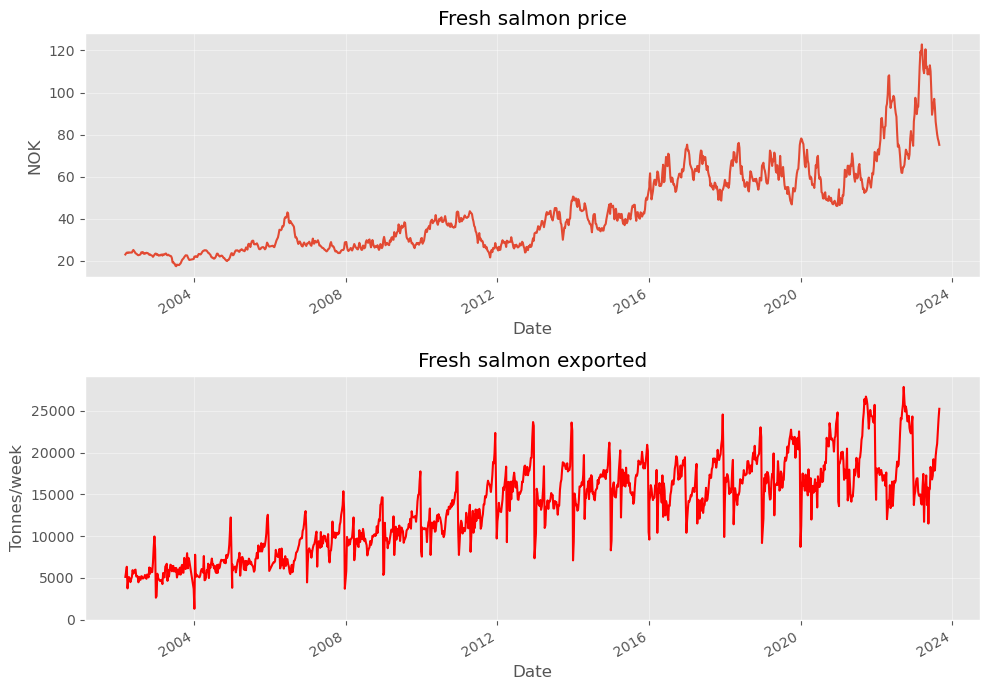

In [19]:

data = pd.read_csv('..\data_files\complete_data.csv', index_col=0, parse_dates=True)

data = data[1:]

add_lags(data)

display(data)

future_dates = future_dates_df(data, 200)

fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 7))

data['Salmon_price'].plot(ax=ax1, ylabel='NOK')
data['Salmon_volume'].plot(ax=ax2, color='red', ylabel='Tonnes/week')
ax1.set_title('Fresh salmon price')
ax2.set_title('Fresh salmon exported')
ax1.grid(alpha=0.4); ax2.grid(alpha=0.4)
ax1.set_xlabel('Date'); ax2.set_xlabel('Date')
fig.tight_layout()

## Data analysis

,Salmon_price,Salmon_volume,Pork_price,Cattle_price,Soybean_price,Wheat_price,Year,Week,Month,Day of year
Date,,,,,,,,,,
2002-03-11,23.05,5121,55.075001,73.000000,467.50,279.00,2002,11,3,70
2002-03-18,23.57,5765,52.950001,69.775002,461.25,281.50,2002,12,3,77
2002-03-25,23.94,6336,51.875000,70.425003,473.50,294.50,2002,13,3,84
2002-04-01,23.79,3748,45.974998,68.675003,460.50,278.75,2002,14,4,91
2002-04-08,24.04,4828,41.950001,65.875000,461.00,272.50,2002,15,4,98
...,...,...,...,...,...,...,...,...,...,...
2023-07-31,83.28,20469,101.025002,180.899994,1444.00,633.00,2023,31,7,212
2023-08-07,80.26,21060,102.099998,180.375000,1401.25,626.75,2023,32,8,219
2023-08-14,78.14,22698,82.125000,178.524994,1362.75,613.25,2023,33,8,226


Salmon_price     0.116217
Salmon_volume   -0.000812
dtype: float64

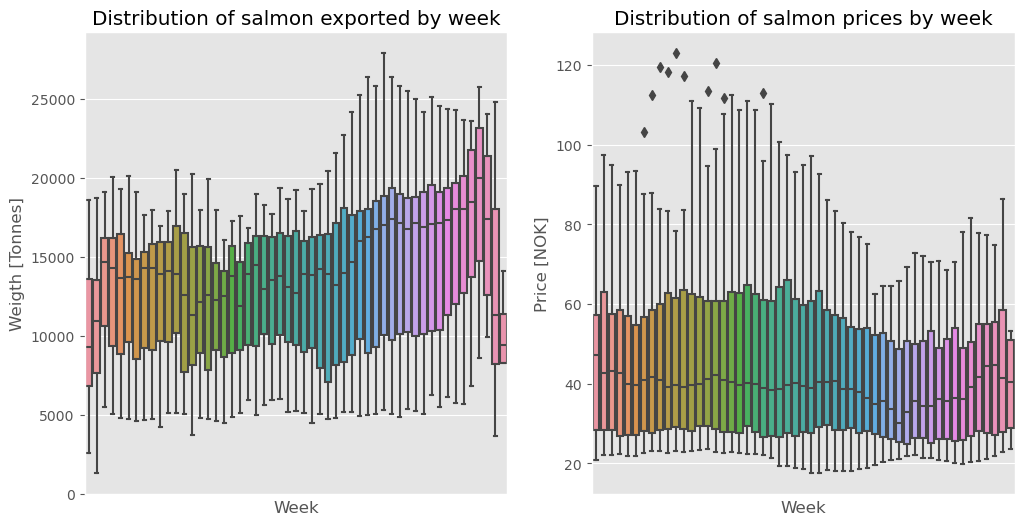

In [20]:
display(data)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
sns.boxplot(data=data, x='Week', y='Salmon_volume', ax=ax1)
sns.boxplot(data=data, x='Week', y='Salmon_price', ax=ax2)
ax1.set_title('Distribution of salmon exported by week')
ax2.set_title('Distribution of salmon prices by week')
ax1.set_xticks([])
ax2.set_xticks([])
ax1.set_ylabel('Weigth [Tonnes]')
ax2.set_ylabel('Price [NOK]')

fig.savefig('images/boxplot.png')

data.groupby('Year').mean()[['Salmon_price', 'Salmon_volume']][-6:].pct_change().mean()

## Features xgb prediction

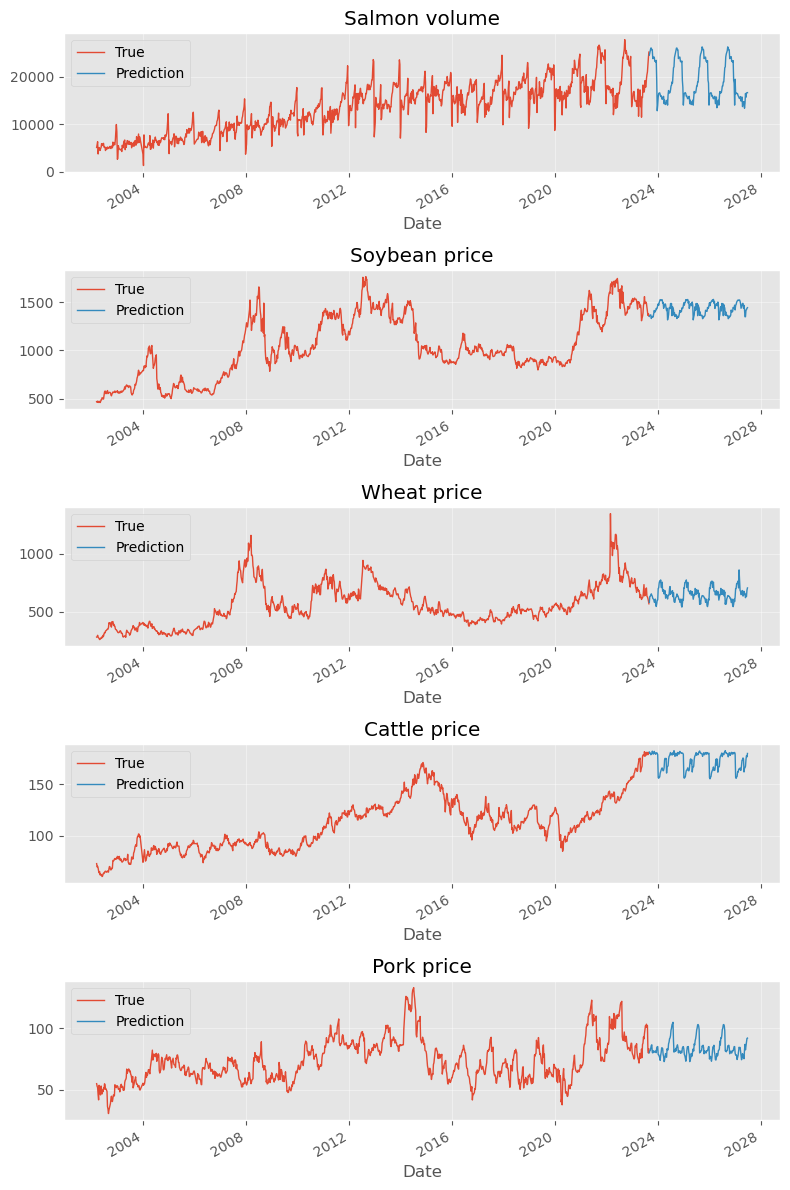

In [25]:
time_features = ['Year', 'Week', 'Month', 'Day of year']

feature_list = ['Salmon_volume', 'Soybean_price', 'Wheat_price', 'Cattle_price', 'Pork_price']

feature_models = dict()
feature_predicitons = pd.DataFrame(index=future_dates.index)

for feature in feature_list:
    model = xgb_model(data, targets=feature, features=time_features)
    model.train_model()
    
    feature_models[feature] = model
    feature_predicitons[feature] = model.predict_df(future_dates)

fig, axs = plt.subplots(len(feature_list), figsize=(8, 12))

for i, feature in enumerate(feature_list):
    data[feature].plot(ax=axs[i], label='True', linewidth=1)
    feature_predicitons[feature].plot(ax=axs[i], label='Prediction', linewidth=1)
    axs[i].set_title(feature.replace('_', ' '))
    axs[i].grid(alpha=0.4)
    axs[i].legend(loc='upper left')

fig.tight_layout()

fig.savefig('images/xgb_features_predictions.png', dpi=200)

## Model training

In [22]:
features = ['Year', 'Week', 'Month', 'Day of year'] + feature_list
targets = ['Salmon_price']


salmon_model = xgb_model(data, targets, features)

for i in range(5):
    salmon_model.train_model(return_model=False, verbose=True)


[0]	validation_0-rmse:33.59181	validation_1-rmse:34.56719
[1]	validation_0-rmse:23.94061	validation_1-rmse:24.55243
[2]	validation_0-rmse:17.21776	validation_1-rmse:17.82551
[3]	validation_0-rmse:12.51054	validation_1-rmse:13.07267
[4]	validation_0-rmse:9.16705	validation_1-rmse:9.85900
[5]	validation_0-rmse:6.85519	validation_1-rmse:7.74991
[6]	validation_0-rmse:5.22105	validation_1-rmse:6.33900
[7]	validation_0-rmse:4.07484	validation_1-rmse:5.40290
[8]	validation_0-rmse:3.33274	validation_1-rmse:4.92100
[9]	validation_0-rmse:2.74491	validation_1-rmse:4.48961
[10]	validation_0-rmse:2.37055	validation_1-rmse:4.26059
[11]	validation_0-rmse:2.05493	validation_1-rmse:4.14470
[12]	validation_0-rmse:1.82653	validation_1-rmse:4.05482
[13]	validation_0-rmse:1.69095	validation_1-rmse:4.01773
[14]	validation_0-rmse:1.57708	validation_1-rmse:4.00302
[15]	validation_0-rmse:1.47987	validation_1-rmse:4.00562
[16]	validation_0-rmse:1.41091	validation_1-rmse:3.99733
[17]	validation_0-rmse:1.33354	va

## Model prediction

,Importance
Year,0.925241
Week,0.006758
Month,0.001486
Day of year,0.006136
Salmon_volume,0.016924
Soybean_price,0.002631
Wheat_price,0.004436
Cattle_price,0.032905
Pork_price,0.003482


,Salmon_price
Date,
2023-09-03,78.779305
2023-09-10,77.584045
2023-09-17,78.720039
2023-09-24,79.615189
2023-10-01,78.766724
...,...
2027-05-30,110.227020
2027-06-06,110.038818
2027-06-13,98.328369


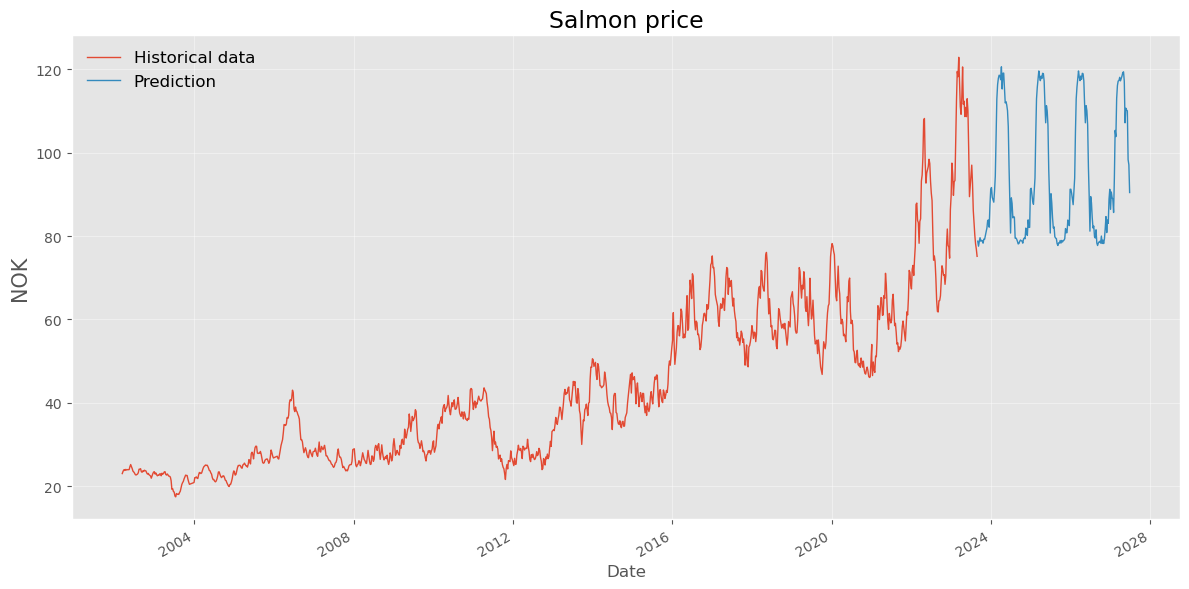

In [23]:

fi = pd.DataFrame(
    data=salmon_model.reg_model.feature_importances_, 
    index=salmon_model.reg_model.feature_names_in_, 
    columns=['Importance'])
display(fi)

future_features = pd.concat([future_dates, feature_predicitons], axis=1)

predictions = pd.DataFrame(salmon_model.predict(future_features), columns=targets, index=future_features.index)

display(predictions)

fig, ax = plt.subplots(figsize=(12, 6))

data['Salmon_price'].plot(ax=ax, label='Historical data', linewidth=1)

predictions['Salmon_price'].plot(ax=ax, linewidth=1, label='Prediction')

ax.legend(fontsize=12, frameon=False)
ax.grid(alpha=0.4)
ax.set_ylabel('NOK', fontsize=15)
ax.set_title('Salmon price', fontsize=17)

fig.tight_layout()

fig.savefig('images/xgb_price_pred.png', dpi=200)

C:\Users\joneh\AppData\Local\Temp\ipykernel_12500\3418264632.py:3: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  october.set_index(october.index.week, inplace=True)


,Salmon_price
Date,
39,78.766724
40,78.984665
41,78.872581
42,78.302399
43,79.287331


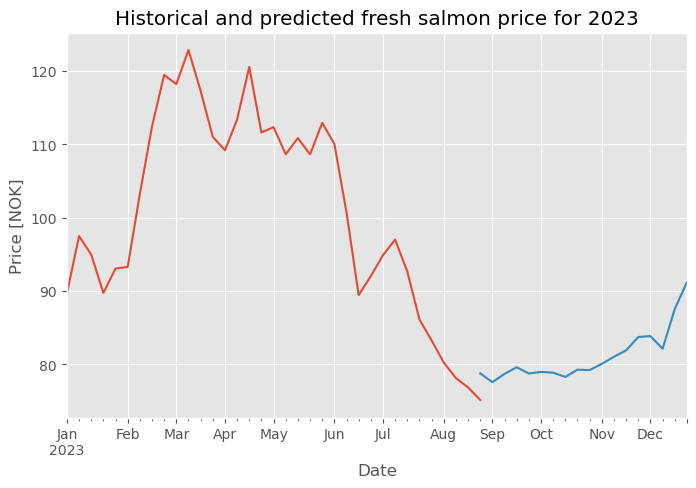

In [24]:
october = predictions[['Salmon_price']].loc[(predictions.index.year == 2023) & (predictions.index.month == 10)]

october.set_index(october.index.week, inplace=True)

display(october)

fig, ax = plt.subplots(figsize=(8, 5))

data['Salmon_price'].loc[data.index.year == 2023].plot(ax=ax)

predictions['Salmon_price'].loc[predictions.index.year == 2023].plot(ax=ax)

ax.set_title('Historical and predicted fresh salmon price for 2023')
ax.set_ylabel('Price [NOK]')

fig.savefig('images/xgb_price_pred_monthly.png', dpi=200)